# 利用机器学习来探究组学信息与深度学习信息的区别

In [1]:
from sklearn import svm
import pandas as pd
import numpy as np
from sklearn import preprocessing, metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score
from sklearn.model_selection import StratifiedKFold
import matplotlib.pylab as plt

In [2]:
def specificity_loss_func(y, y_pred):
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    return tn/(tn+fp)


def print_summary(results):
    print("Accuracy: %.2f%% ± %.2f%%" %
          (np.mean(results['acc']) * 100, np.std(results['acc']) * 100))
    print("Sensitivity: %.2f%% ± %.2f%%" %
          (np.mean(results['sens']) * 100, np.std(results['sens']) * 100))
    print("Specificity: %.2f%% ± %.2f%%" %
          (np.mean(results['spec']) * 100, np.std(results['spec']) * 100))
    print("F1-score: %.2f%% ± %.2f%%" %
          (np.mean(results['f1_score']) * 100, np.std(results['f1_score']) * 100))
    print("AUC: %.2f ± %.2f" %
          (np.mean(results['auc']) * 100, np.std(results['auc']) * 100))


def get_model(kernel='rbf', C=1.0, gamma='scale', probability=False):
    model = svm.SVC(kernel=kernel, C=C, gamma=gamma,
                    probability=probability, class_weight='balanced')
    return model


def read_data(path):
    data = pd.read_csv(path, usecols=lambda column: column not in ["class"])
    data = np.array(data)

    classes = pd.read_csv(path, usecols=["class"])
    Y = classes.values.ravel()

    # Minmax scaling
    min_max_scaler = preprocessing.MinMaxScaler()
    X = min_max_scaler.fit_transform(data)

    return X, Y


def validate(model, X, Y,plot = False):
    cv = StratifiedKFold(n_splits=10, shuffle=True)

    # Results dict
    results = {'acc': [], 'spec': [], 'sens': [], 'f1_score': [], 'auc': []}

    # Needed for ROC
    fig1 = 0
    if plot==True:
        i = 0
        fig1 = plt.figure(figsize=[11, 11])
        tprs, aucs = [], []
        mean_fpr = np.linspace(0, 1, 100)


    # Cross-validation
    for train, test in cv.split(X, Y):
        model = model.fit(X[train], Y[train])

        # Generating predictions
        predicted = model.predict(X[test])
        predicted_proba = model.predict_proba(X[test])

        results['acc'].append(accuracy_score(Y[test], predicted))
        results['f1_score'].append(f1_score(Y[test], predicted))
        results['spec'].append(specificity_loss_func(Y[test], predicted))
        results['sens'].append(recall_score(Y[test], predicted))
        results['auc'].append(roc_auc_score(Y[test], predicted_proba[:, 1]))

        # Composing ROC curve
        if plot==True:
            i += 1

            fpr, tpr, t = metrics.roc_curve(Y[test], predicted_proba[:, 1])
            tprs.append(np.interp(mean_fpr, fpr, tpr))
            #roc_auc = metrics.auc(fpr, tpr)
            roc_auc = results['auc'][i-1]
            aucs.append(roc_auc)
        
            plt.plot(fpr, tpr, lw=2, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    if plot==True:
      mean_tpr = np.mean(tprs, axis=0)
      mean_auc = metrics.auc(mean_fpr, mean_tpr)
      plt.plot(mean_fpr, mean_tpr, color='blue',
                  label=r'Mean ROC (AUC = %0.2f )' % (mean_auc), lw=2, alpha=1)
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('ROC')
      plt.legend(loc="lower right")
      plt.show()
      plt.close('all')

    return results

## 利用深度学习信息

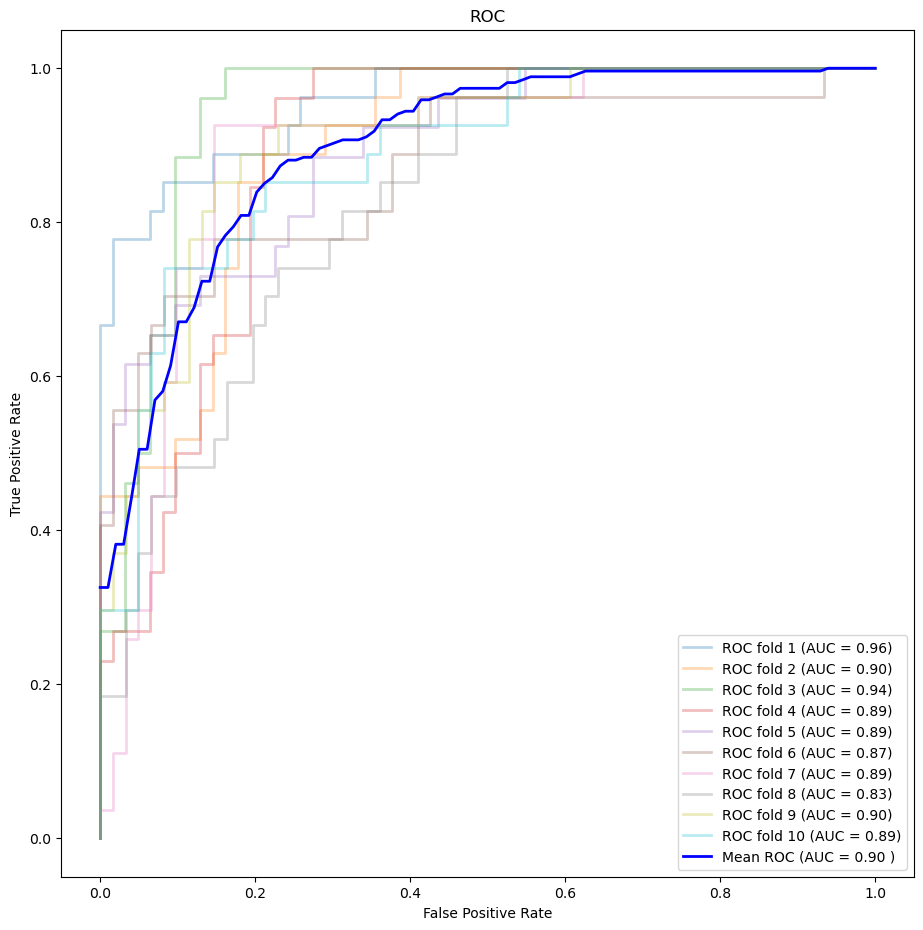

Accuracy: 81.51% ± 4.15%
Sensitivity: 84.34% ± 7.17%
Specificity: 80.33% ± 5.31%
F1-score: 73.50% ± 5.06%
AUC: 89.60 ± 3.30


In [3]:
if __name__ == "__main__":
    model = get_model(probability=True)
    X, Y = read_data("../data/deep_radiomics.csv")
    results = validate(model, X, Y, plot = True)
    print_summary(results)

## 利用组学信息内容

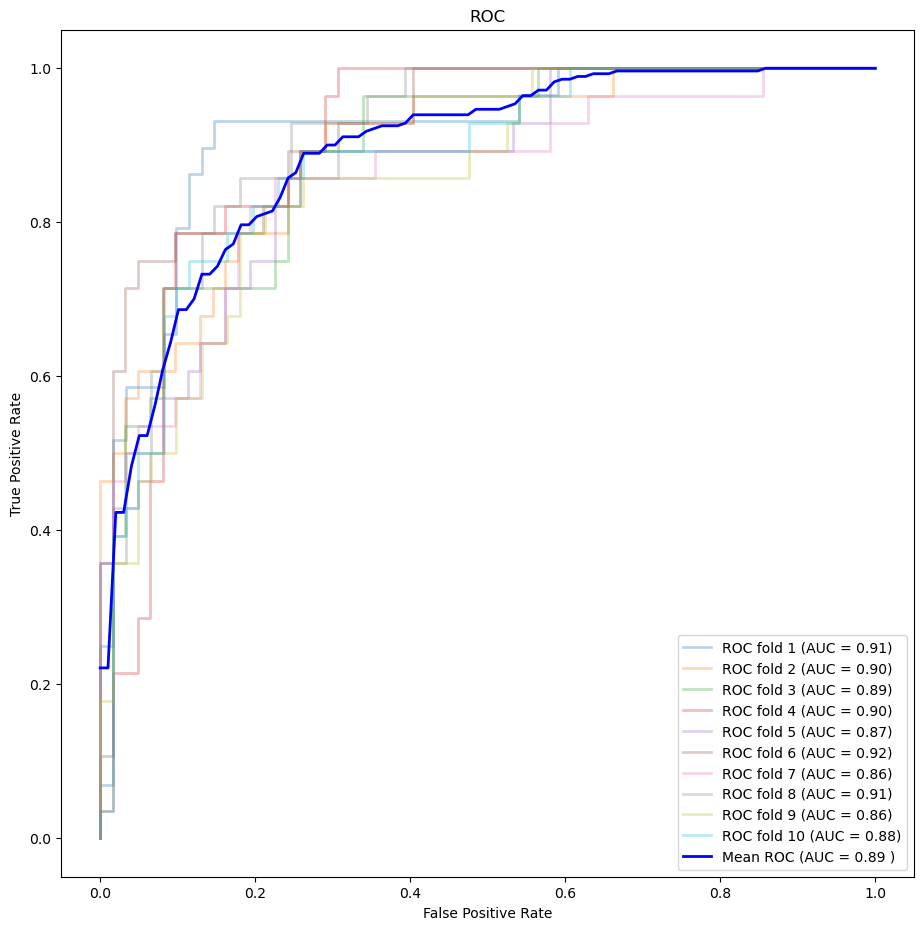

Accuracy: 80.72% ± 2.74%
Sensitivity: 80.05% ± 4.64%
Specificity: 81.03% ± 4.19%
F1-score: 72.27% ± 3.48%
AUC: 88.91 ± 2.26


In [4]:
if __name__ == "__main__":
    model = get_model(probability=True)
    X, Y = read_data("../data/radiomics.csv")
    results = validate(model, X, Y, plot = True)
    print_summary(results)